**Task - 6 :- Real-time Multi-Object Colorization with Semantic Segmentation**

In [ ]:
!pip install -q torch torchvision opencv-python-headless matplotlib

import cv2
import numpy as np
import torch
from torchvision import models, transforms
from google.colab.patches import cv2_imshow
from google.colab import files
from IPython.display import clear_output
import os


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.5 MB/s eta 0:00:00


In [ ]:
# Load pretrained DeepLabV3 model
model = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

# Define color mapping for simplified labels
LABEL_COLORS = {
    0: (0, 0, 0),          # background
    1: (70, 70, 70),       # person
    2: (128, 64, 128),     # car
    3: (107, 142, 35),     # tree
    4: (70, 130, 180),     # road
    5: (220, 20, 60),      # animal
}

SIMPLIFIED_LABELS = {
    15: 1,  # person
    2: 2,   # car
    21: 3,  # tree
    7: 4,   # road
    17: 5,  # animal
}

# Define input transform
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((520, 520)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def segment_and_colorize(frame):
    input_tensor = preprocess(frame).unsqueeze(0)
    with torch.no_grad():
        output = model(input_tensor)['out'][0]
    output_predictions = output.argmax(0).cpu().numpy()

    colored_mask = np.zeros((output_predictions.shape[0], output_predictions.shape[1], 3), dtype=np.uint8)
    for coco_label, simple_label in SIMPLIFIED_LABELS.items():
        colored_mask[output_predictions == coco_label] = LABEL_COLORS[simple_label]

    mask_resized = cv2.resize(colored_mask, (frame.shape[1], frame.shape[0]), interpolation=cv2.INTER_NEAREST)
    blended = cv2.addWeighted(frame, 0.5, mask_resized, 0.5, 0)
    return blended


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 144MB/s]


In [ ]:
uploaded = files.upload()
video_path = list(uploaded.keys())[0]


Saving sample video.mp4 to sample video.mp4


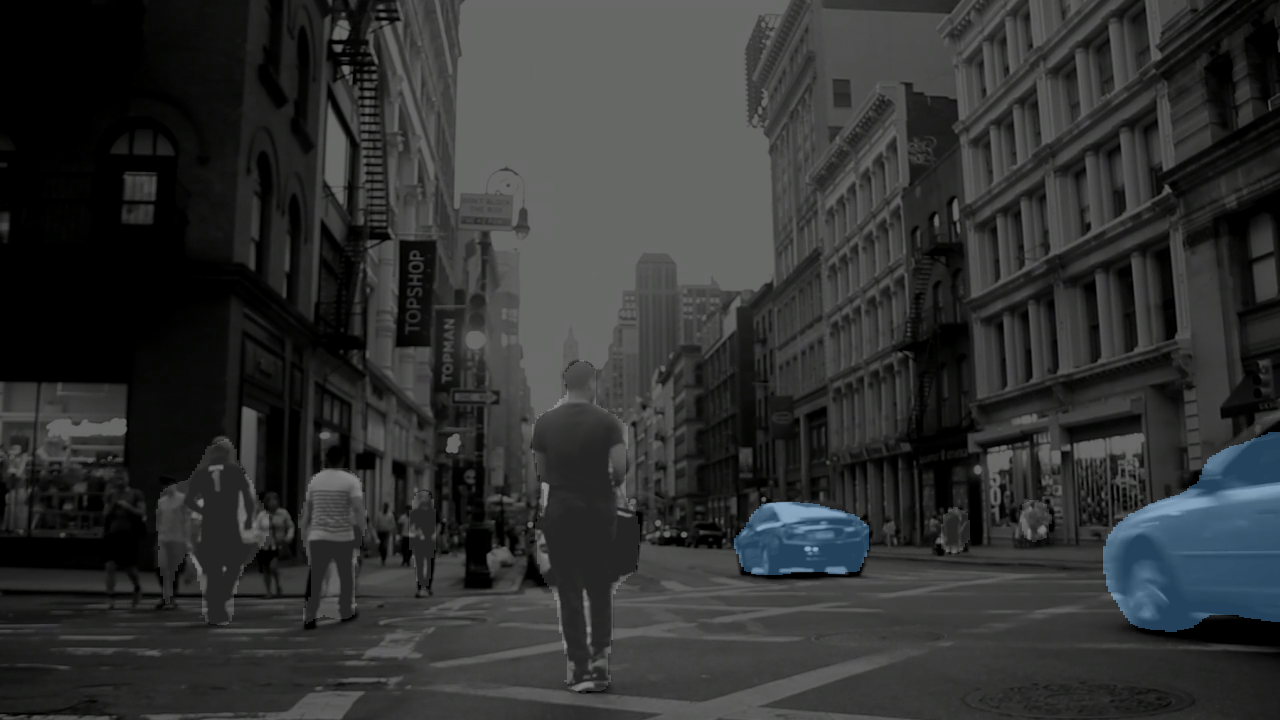

In [ ]:
cap = cv2.VideoCapture(video_path)

frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret or frame_count > 200:  # Limit for demo
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    output = segment_and_colorize(frame_rgb)
    output_bgr = cv2.cvtColor(output, cv2.COLOR_RGB2BGR)

    clear_output(wait=True)
    cv2_imshow(output_bgr)
    frame_count += 1
    cv2.waitKey(1)

cap.release()
cv2.destroyAllWindows()
